# Import

In [149]:
import numpy as np
import pandas as pd
import math, itertools
from itertools import combinations, product
from typing import List, Dict, Tuple, Iterable, Any

from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Polygon
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PatchCollection

import plotly.graph_objects as go
from plotly.colors import sample_colorscale

import torch
import cvxpy as cp
import torch.nn.functional as F
from scipy.optimize import linprog
from scipy.optimize import minimize

from dnn_dro import *
from dnn_dro.experiments import *

# Toy Case

## Checking Inequalities

| **column in the DataFrame** | **what it measures**                                                                      | **inequality it should satisfy** |
| --------------------------- | ----------------------------------------------------------------------------------------- | -------------------------------- |
| `max_diff_over_grad`        | $\displaystyle\max_{x'}\frac{\lvert\psi(x')-\psi(x)\rvert}{\sqrt2\,\|J\|_2\,\|x'-x\|_2}$ | ≤ 1                              |
| `max_grad_over_L`          | $\displaystyle\max_{x'}\frac{\sqrt2\,\|J\|_2\,\|x'-x\|_2}{L\,\|x'-x\|_2}$              | ≤ 1                              |
| `max_diff_over_L`          | $\displaystyle\max_{x'}\frac{\lvert\psi(x')-\psi(x)\rvert}{L\,\|x'-x\|_2}$             | ≤ 1                              |


In [69]:
df_mc = pd.DataFrame([run_mc(s) for s in range(5)])
df_mc

,seed,J_norm,L,max_diff_over_grad,max_grad_over_L,max_diff_over_L
0,0,3.410633,5.602598,0.212022,0.860915,0.182533
1,1,5.326426,9.167764,0.834509,0.821651,0.685675
2,2,2.163410,3.390772,0.271887,0.902309,0.245326
3,3,2.503901,5.091682,0.203883,0.695458,0.141792
4,4,2.743037,4.582976,0.707384,0.846446,0.598762


---

| column name in the DataFrame| what the numbers are|
|---------------------------- | ------------------- |
| `ratio_single`| $\displaystyle\frac{\lvert\psi(x')-\psi(x)\rvert}{\sqrt2\,\|J\|_2\,\|x'-x\|_2}$|
| `ratio_path`| $\displaystyle\frac{\lvert\psi(x')-\psi(x)\rvert}{\sqrt2\,\|J^{(*)}\|_2\,\|x'-x\|_2}$ |
| `ratio_L`| $\displaystyle\frac{\lvert\psi(x')-\psi(x)\rvert}{L\,\|x'-x\|_2}$|
| `n_segs`| how many linear **segments** the straight path $x \to x'$ was broken into|


In [70]:
df_path = run_path(0)
df_path.describe()[["ratio_single","ratio_path","ratio_L","n_segs"]]

,ratio_single,ratio_path,ratio_L,n_segs
count,200.000000,200.000000,200.000000,200.000000
mean,0.056655,0.055776,0.048775,1.525000
std,0.035552,0.034824,0.030608,0.686829
min,0.001366,0.001366,0.001176,1.000000
25%,0.027104,0.026655,0.023334,1.000000
50%,0.052644,0.050564,0.045322,1.000000
75%,0.078963,0.078563,0.067981,2.000000
max,0.162534,0.162534,0.139928,4.000000


---

| column                       | what it is|
| ---------------------------- | ------------------------------------------                         |
| **`‖W2‖₂·‖W1‖₂`**            | product of the *individual* spectral norms                         |                
| **`‖W2·W1‖₂`**               | spectral norm of the *full* linear map $W_2W_1$ (no ReLU masking)  |
| **`max‖W2·D·W1‖₂`**          | largest norm over all $2^{\,n_1}$ binary masks $D$                 |
| **`min‖W2·D·W1‖₂`**          | smallest masked norm                                               |
| **`ratio (max / prod)`**     | $\dfrac{\text{max‖W2DW1‖₂}}{\|W_2\|_2\|W_1\|_2}$                   |
| **`ratio (max / full)`**     | $\dfrac{\text{max‖W2DW1‖₂}}{\|W_2W_1\|_2}$                         |


In [71]:
df = pd.DataFrame(compare_norms(s) for s in range(5))
df

,seed,‖W₂‖₂·‖W₁‖₂,‖W₂W₁‖₂,max‖W₂DW₁‖₂,min‖W₂DW₁‖₂,ratio (max / prod),ratio (max / full)
0,0,6.336818,3.700935,3.961635,0.0,0.625177,1.070442
1,1,8.472053,6.397124,6.482588,0.0,0.765173,1.013360
2,2,4.141385,2.397638,2.397638,0.0,0.578946,1.000000
3,3,3.784182,3.600363,3.600363,0.0,0.951424,1.000000
4,4,5.681056,3.240654,3.240654,0.0,0.570431,1.000000


## Compare with Rui Gao

Rui Gao
$$
\left| \mathcal R_{\mathbb P_n,2}(\rho_n;f_\theta)-\rho_n\,\left\|\left\|\nabla f_\theta\right\|_{*}\right\|_{\mathbb P_n,2} \right|
\;\le\;
C_1\rho_n^{\!2}
\;+\;
C_2\,d_1\sqrt{\frac{d}{n}}
\;+\;
\rho_n\sqrt{\frac{t}{2n}}
$$
$$
\mathcal R_{\mathbb P_N,2}(\delta;\psi_\beta) = \sup_{\mathbb{P} \in \mathfrak{M}_1} \left\{\text{E}_\mathbb{P}[\psi_\beta(Z)]\right\} - \text{E}_{\mathbb{P}_N}[\psi_\beta(Z)] 
$$
$$
\sup_{\mathbb{P} \in \mathfrak{M}_1} \left\{\text{E}_\mathbb{P}[\psi_\beta(Z)]\right\} - \text{E}_{\mathbb{P}_N}[\psi_\beta(Z)] \leq \delta\,\left\|\left\|\nabla \psi_\beta\right\|_{*}\right\|_{\mathbb P_N,2} + C_1\delta^{2}
\;+\;
C_2\,n_1\sqrt{\frac{n}{N}}
\;+\;
\delta\sqrt{\frac{t}{2N}}
$$
$$
C_1=\tfrac18, \quad C_2=\sqrt3.
$$
$$
\sup_{\mathbb{P} \in \mathfrak{M}_1} \left\{\text{E}_\mathbb{P}[\psi_\beta(Z)]\right\} - \text{E}_{\mathbb{P}_N}[\psi_\beta(Z)] \leq \delta\,\left\|\left\|\nabla \psi_\beta\right\|_{*}\right\|_{\mathbb P_N,2} + \tfrac18\delta^{2}
\;+\;
\sqrt3\,n_1\sqrt{\frac{n}{N}}
\;+\;
\delta\sqrt{\frac{t}{2N}}
$$

Our Problem
$$
\sup_{\mathbb{P} \in \mathfrak{M}_1} \left\{\text{E}_\mathbb{P}[\psi_\beta(Z)]\right\} - \text{E}_{\mathbb{P}_N}[\psi_\beta(Z)] 
\leq L\,\delta
\;
$$
$$
\mathfrak{M}_1 := \{\mathbb{P}\in \mathcal{P}(\mathcal{Z}) \ | \ \mathcal{W}_{d,1}(\mathbb{P}, \mathbb{P}_N) \leq \delta \}
$$

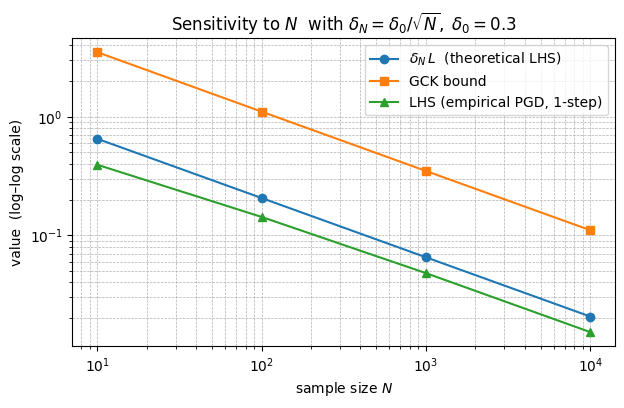

In [54]:
df_decay = compare_bounds(delta0=0.3, constant_radius=False)
plt.figure(figsize=(7,4))
plt.plot(df_decay.N, df_decay.ours,     marker="o", label=r"$\delta_N\,L$  (theoretical LHS)")
plt.plot(df_decay.N, df_decay.gck,      marker="s", label=r"GCK bound")
plt.plot(df_decay.N, df_decay.lhs_emp,  marker="^", label=r"LHS (empirical PGD, 1-step)")
plt.xscale("log"); plt.yscale("log")
plt.xlabel(r"sample size $N$")
plt.ylabel("value  (log-log scale)")
plt.title(rf"Sensitivity to $N$  with $\delta_N=\delta_0/\sqrt{{N}},\;\delta_0={0.3}$")
plt.grid(True, which="both", ls="--", lw=0.5)
plt.legend()
plt.show()

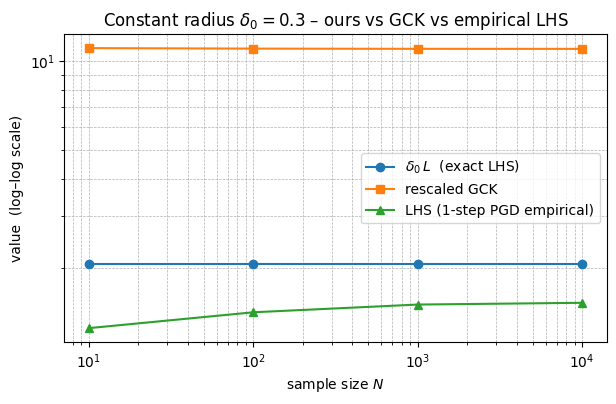

In [55]:
df_const = compare_bounds(delta0=0.3, constant_radius=True)
plt.figure(figsize=(7,4))
plt.plot(df_const.N, df_const.ours,     marker="o", label=r"$\delta_0\,L$  (exact LHS)")
plt.plot(df_const.N, df_const.gck,      marker="s", label=r"rescaled GCK")
plt.plot(df_const.N, df_const.lhs_emp,  marker="^", label=r"LHS (1-step PGD empirical)")
plt.xscale("log"); plt.yscale("log")
plt.xlabel(r"sample size $N$")
plt.ylabel("value  (log–log scale)")
plt.title(rf"Constant radius $\delta_0={0.3}$ – ours vs GCK vs empirical LHS")
plt.grid(True, which="both", ls="--", lw=0.5)
plt.legend()
plt.show()

## Checking Topology

$$\mathcal D = \mathcal D _{(i)}$$

In [72]:
check_mask_topology()


[Step 1] Found 59 distinct feasible masks out of 64 possible.

[Step 2] Feasible masks 𝓓:
{ 000000, 000001, 000010, 000011, 000100, 000101, 000110, 000111, 001000, 001010, 001011, 001100, 001101, 001110, 001111, 010000, 010010, 010011, 010100, 010101, 010110, 010111, 011000, 011010, 011011, 011100, 011101, 011110, 011111, 100000, 100001, 100010, 100011, 100100, 100101, 100111, 101000, 101001, 101010, 101011, 101100, 101101, 101111, 110000, 110001, 110010, 110011, 110100, 110101, 110110, 110111, 111000, 111001, 111010, 111011, 111100, 111101, 111110, 111111 }

[Step 3] Segment-tail masks 𝓓(i):
{ 000000, 000001, 000010, 000011, 000100, 000101, 000110, 000111, 001000, 001010, 001011, 001100, 001101, 001110, 001111, 010000, 010010, 010011, 010100, 010101, 010110, 010111, 011000, 011010, 011011, 011100, 011101, 011110, 011111, 100000, 100001, 100010, 100011, 100100, 100101, 100111, 101000, 101001, 101010, 101011, 101100, 101101, 101111, 110000, 110001, 110010, 110011, 110100, 110101, 11011

$$
J^*u = w
$$

In [147]:
W1, W2, D_star, J_star, radius, w, u, c, j_plus = build_D2_satisfying(n1=4)
pretty_print_D2(W1, W2, D_star, J_star, radius, w, u, c, j_plus)


=== NETWORK INGREDIENTS ===
W1 =
[[-0.6436  0.3784]
 [ 0.7196  1.7698]
 [ 1.3441  1.0055]
 [-0.351  -0.7537]]

W2 =
[[-0.9808 -0.655  -1.0012 -0.2473]
 [ 0.491  -0.1602  1.8371 -0.1348]]

D* (bitstring) = 0110
D* =
[[0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 0.]]

J* =
[[-1.8171 -2.1659]
 [ 2.354   1.5638]]

‖J*‖₂ = 3.9566

=== STRICT ReLU CELL 𝒞* ===
  (I−D*)W1[0] · x < 0   (⇒ -0.6436·x₁ +0.3784·x₂ < 0)
  D*W1[1] · x > 0   (⇒ +0.7196·x₁ +1.7698·x₂ > 0)
  D*W1[2] · x > 0   (⇒ +1.3441·x₁ +1.0055·x₂ > 0)
  (I−D*)W1[3] · x < 0   (⇒ -0.3510·x₁ -0.7537·x₂ < 0)

=== RECESSION CONE rec(𝒞*) ===
  (I−D*)W1[0] · u ≤ 0   (⇒ -0.6436·u₁ +0.3784·u₂ ≤ 0)
  D*W1[1] · u ≥ 0   (⇒ +0.7196·u₁ +1.7698·u₂ ≥ 0)
  D*W1[2] · u ≥ 0   (⇒ +1.3441·u₁ +1.0055·u₂ ≥ 0)
  (I−D*)W1[3] · u ≤ 0   (⇒ -0.3510·u₁ -0.7537·u₂ ≤ 0)
Ω = int(rec(𝒞*))  (all inequalities strict)

=== IMAGE CONE V AND SLICE V* ===
V = J* Ω  (linear image of the interior cone)
Sphere radius = ‖J*‖₂ = 3.9566
V* = V ∩ { z : ‖z‖₂ = ‖J*‖₂ }

In [ ]:
# Z_i = [np.random.uniform(low=-2, high=2, size=2)]
Z_i = np.array([0, -1])

In [23]:
a2_data = compute_a2_data(W1, W2, J_star, Z_i, u, radius, y_true=c)

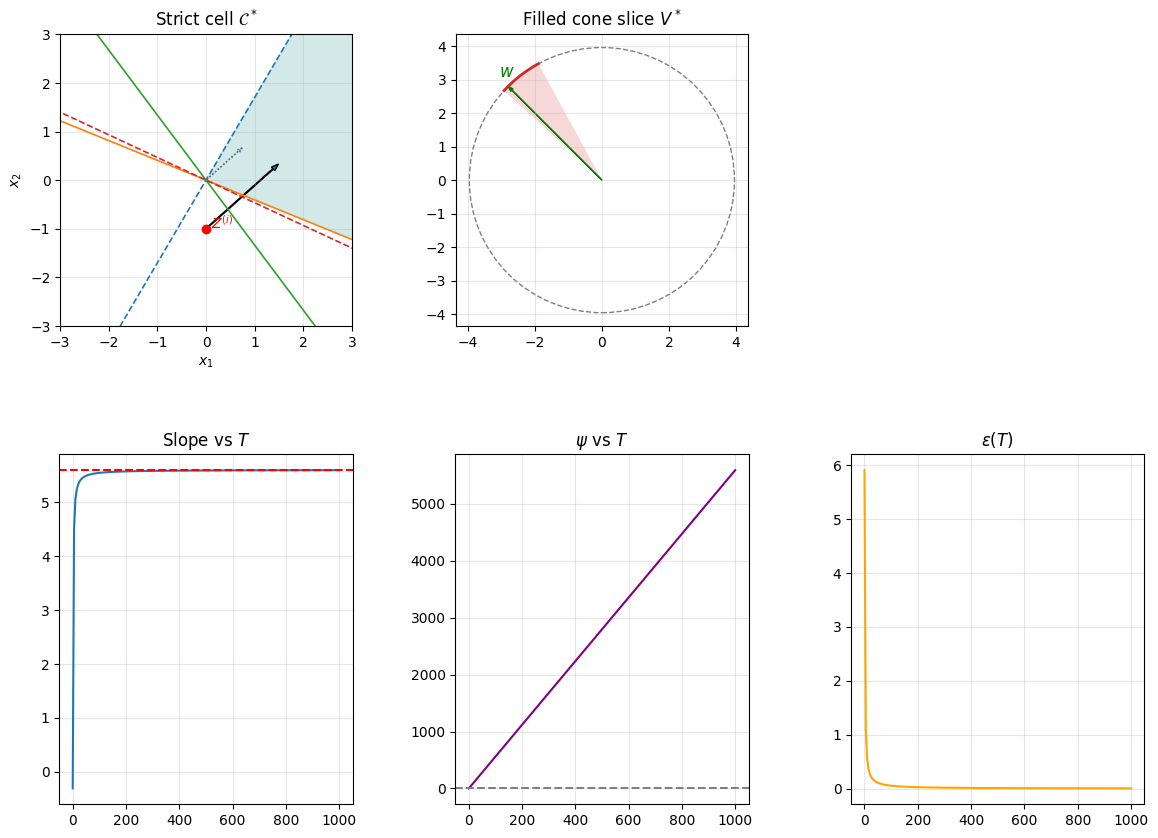

In [44]:
plot_assumption_a2(W1, W2, D_star, J_star, Z_i, u, radius, a2_data, w = w)

## Loss Surface

In [413]:
# ----- parameters ------------------------------------------------
BOX = torch.tensor([-10, 6])     # grid range
pts_all = torch.tensor([[-3,-1],[0,-3],[-2,2],[1,1]], dtype=torch.float32)
labels  = torch.tensor([0,0,1,1])
T_LEN = 5

In [372]:
# Loss surface visualization
# ----- Cross-entropy helper -----
def forward_loss(W1: torch.Tensor, W2: torch.Tensor, X: torch.Tensor, c: int) -> torch.Tensor:
    """Compute cross-entropy loss for inputs X with class label c."""
    logits = W2 @ relu(W1 @ X.T)  # shape: (K, N)
    targets = torch.full((X.shape[0],), c, dtype=torch.long)
    return cross_entropy(logits.T, targets, reduction='none')  # (N,)

# Ensure W1, W2, u are tensors (convert if they are numpy arrays)
if not isinstance(W1, torch.Tensor):
    W1 = torch.tensor(W1, dtype=torch.float32)
else:
    W1 = W1.clone().detach().float()

if not isinstance(W2, torch.Tensor):
    W2 = torch.tensor(W2, dtype=torch.float32)
else:
    W2 = W2.clone().detach().float()

if not isinstance(u, torch.Tensor):
    u = torch.tensor(u, dtype=torch.float32)
else:
    u = u.clone().detach().float()


# ----- 2. compute loss (z-coord) for each sampled point ----------
z_vals = forward_loss(W1, W2, pts_all, c)  # keep as tensor

# ----- 3. build the surface --------------------------------------
grid   = torch.linspace(BOX[0], BOX[1], 200)
xx, yy = torch.meshgrid(grid, grid, indexing='ij')
XY     = torch.stack([xx.reshape(-1), yy.reshape(-1)], dim=1)  # (N,2)
loss_grid = forward_loss(W1, W2, XY, c).reshape(xx.shape)

# ----- 4. plot surface + scatter points -------------------------
fig = go.Figure()

# Loss surface
fig.add_trace(
    go.Surface(
        x=xx.numpy(), y=yy.numpy(), z=loss_grid.numpy(),
        colorscale='Viridis', opacity=0.8,
        showscale=True, colorbar=dict(title='Loss', x=-0.15)
    )
)

# Masks for labels
mask0 = labels == 0
mask1 = ~mask0

# Scatter points (above surface & projections)
for mask in [mask0, mask1]:
    fig.add_trace(go.Scatter3d(
        x=pts_all[mask,0].numpy(), y=pts_all[mask,1].numpy(), z=z_vals[mask].numpy(),
        mode='markers', marker=dict(size=5, color='red'), showlegend=False
    ))
    fig.add_trace(go.Scatter3d(
        x=pts_all[mask,0].numpy(), y=pts_all[mask,1].numpy(), z=torch.zeros_like(z_vals[mask]).numpy(),
        mode='markers', marker=dict(size=4, color='red', symbol='diamond'), showlegend=False
    ))

# Vertical connectors
for (x, y, z) in zip(pts_all[:,0], pts_all[:,1], z_vals):
    fig.add_trace(go.Scatter3d(
        x=[x.item(), x.item()], y=[y.item(), y.item()], z=[0, z.item()],
        mode='lines', line=dict(color='gray', dash='dash'), showlegend=False
    ))

# Witness direction u as arrows
for idx, (x0, y0) in enumerate(pts_all):
    xy0 = torch.tensor([x0, y0])
    xy1 = xy0 + T_LEN * u
    z_end = forward_loss(W1, W2, xy1.unsqueeze(0), c).item()

    # endpoint markers
    fig.add_trace(go.Scatter3d(x=[xy1[0].item()], y=[xy1[1].item()], z=[0],
                               mode='markers', marker=dict(size=2, color='black', symbol='x'), showlegend=False))
    fig.add_trace(go.Scatter3d(x=[xy1[0].item()], y=[xy1[1].item()], z=[z_end],
                               mode='markers', marker=dict(size=2, color='black', symbol='square'), showlegend=False))
    # connectors
    fig.add_trace(go.Scatter3d(
        x=[x0.item(), xy1[0].item()], y=[y0.item(), xy1[1].item()], z=[z_vals[idx].item(), z_end],
        mode='lines', line=dict(color='black'), showlegend=False
    ))
    fig.add_trace(go.Scatter3d(
        x=[xy1[0].item(), xy1[0].item()], y=[xy1[1].item(), xy1[1].item()], z=[0, z_end],
        mode='lines', line=dict(color='gray', dash='dash'), showlegend=False
    ))
    fig.add_trace(go.Scatter3d(
        x=[x0.item(), xy1[0].item()], y=[y0.item(), xy1[1].item()], z=[0, 0],
        mode='lines', line=dict(color='black', width=2), showlegend=False
    ))

# Layout
fig.update_layout(
    title='Loss surface',
    scene=dict(
        xaxis_title='x₁', yaxis_title='x₂', zaxis_title='Loss',
        camera=dict(eye=dict(x=1.5, y=1.4, z=1.0))
    ),
    width=850, height=650
)

fig.show()

## Assumptions Check

$$
\begin{aligned}
&\text{Fix the training label $c \in \{1,...,K\}$, there exists $j_+ \ne c$ and a unit vector $u \in \Omega$, such that}\\
& \hspace{72pt} J^*u = w :=  \frac{\left\|J^*\right\|_2}{\sqrt{2}}(e_{j_+} - e_{c}) \; , \quad \left\|w\right\|_2 = \left\|J^*\right\|_2, \quad w\in V_*\\
&\text{with $e_j$ being the $j$-th canonical basis vector.}
\end{aligned}
$$

In [179]:
# ----- Run experiments | Base case: n=2, n1=4, K=2 -----
trials = 100000
fixed = {'n': 2, 'n1': 4, 'K': 2}

# 1. Sensitivity to n
df_n = estimate_d2_probability('n', [2, 4, 6, 8, 10], fixed, trials)

# 2. Sensitivity to n1
df_n1 = estimate_d2_probability('n1', [2, 4, 6, 8, 10], fixed, trials)

# 3. Sensitivity to K
df_K = estimate_d2_probability('K', [2, 4, 6, 8, 10], fixed, trials)

n=2, prob=0.01%, success=10, trials=100000
n=4, prob=0.0%, success=0, trials=100000
n=6, prob=0.0%, success=0, trials=100000
n=8, prob=0.0%, success=0, trials=100000
n=10, prob=0.0%, success=0, trials=100000
n1=2, prob=0.02%, success=20, trials=100000
n1=4, prob=0.01%, success=10, trials=100000
n1=6, prob=0.0%, success=0, trials=100000
n1=8, prob=0.001%, success=1, trials=100000
n1=10, prob=0.0%, success=0, trials=100000
K=2, prob=0.01%, success=10, trials=100000
K=4, prob=0.0%, success=0, trials=100000
K=6, prob=0.0%, success=0, trials=100000
K=8, prob=0.0%, success=0, trials=100000
K=10, prob=0.0%, success=0, trials=100000


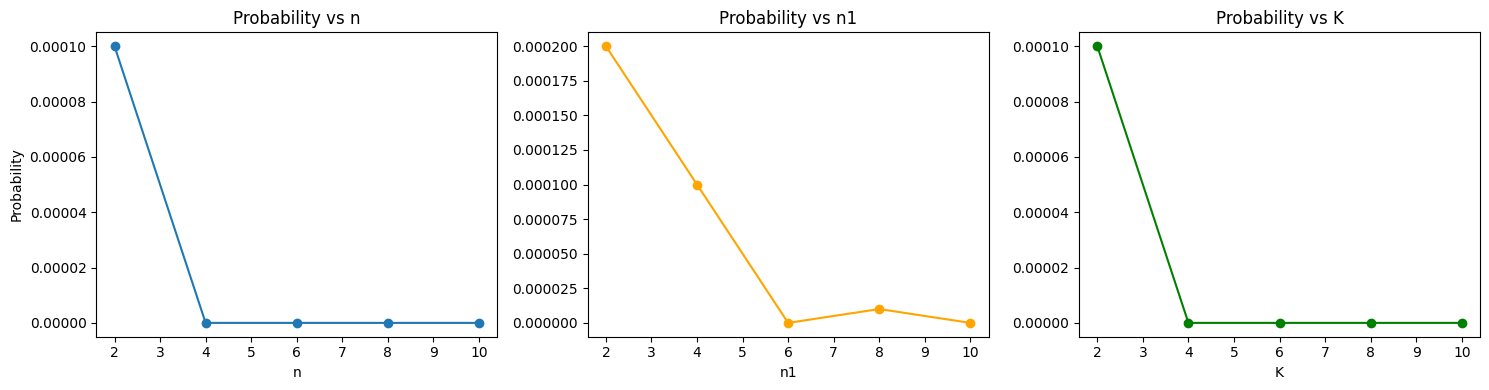

In [180]:
# ----- Plotting -----
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.plot(df_n['n'], df_n['probability'], marker='o')
plt.title('Probability vs n')
plt.xlabel('n'); plt.ylabel('Probability')

plt.subplot(1, 3, 2)
plt.plot(df_n1['n1'], df_n1['probability'], marker='o', color='orange')
plt.title('Probability vs n1')
plt.xlabel('n1')

plt.subplot(1, 3, 3)
plt.plot(df_K['K'], df_K['probability'], marker='o', color='green')
plt.title('Probability vs K')
plt.xlabel('K')

plt.tight_layout()
plt.show()